## Cilia quantification
The purpose of this notebook is to implement scikit image regionprops to populate a table with the characteristics of each segmented cilia.

In [1]:
from morphocilia.io import load_rescaled_channel
from morphocilia.segmenter import cilia_segmenter_cleaner
import napari
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.measure import regionprops_table
import seaborn as sns

c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
DATA_DIR = Path("../data")

filepath = DATA_DIR / "20231025_p1_cd13_opn_arl13b.lif"

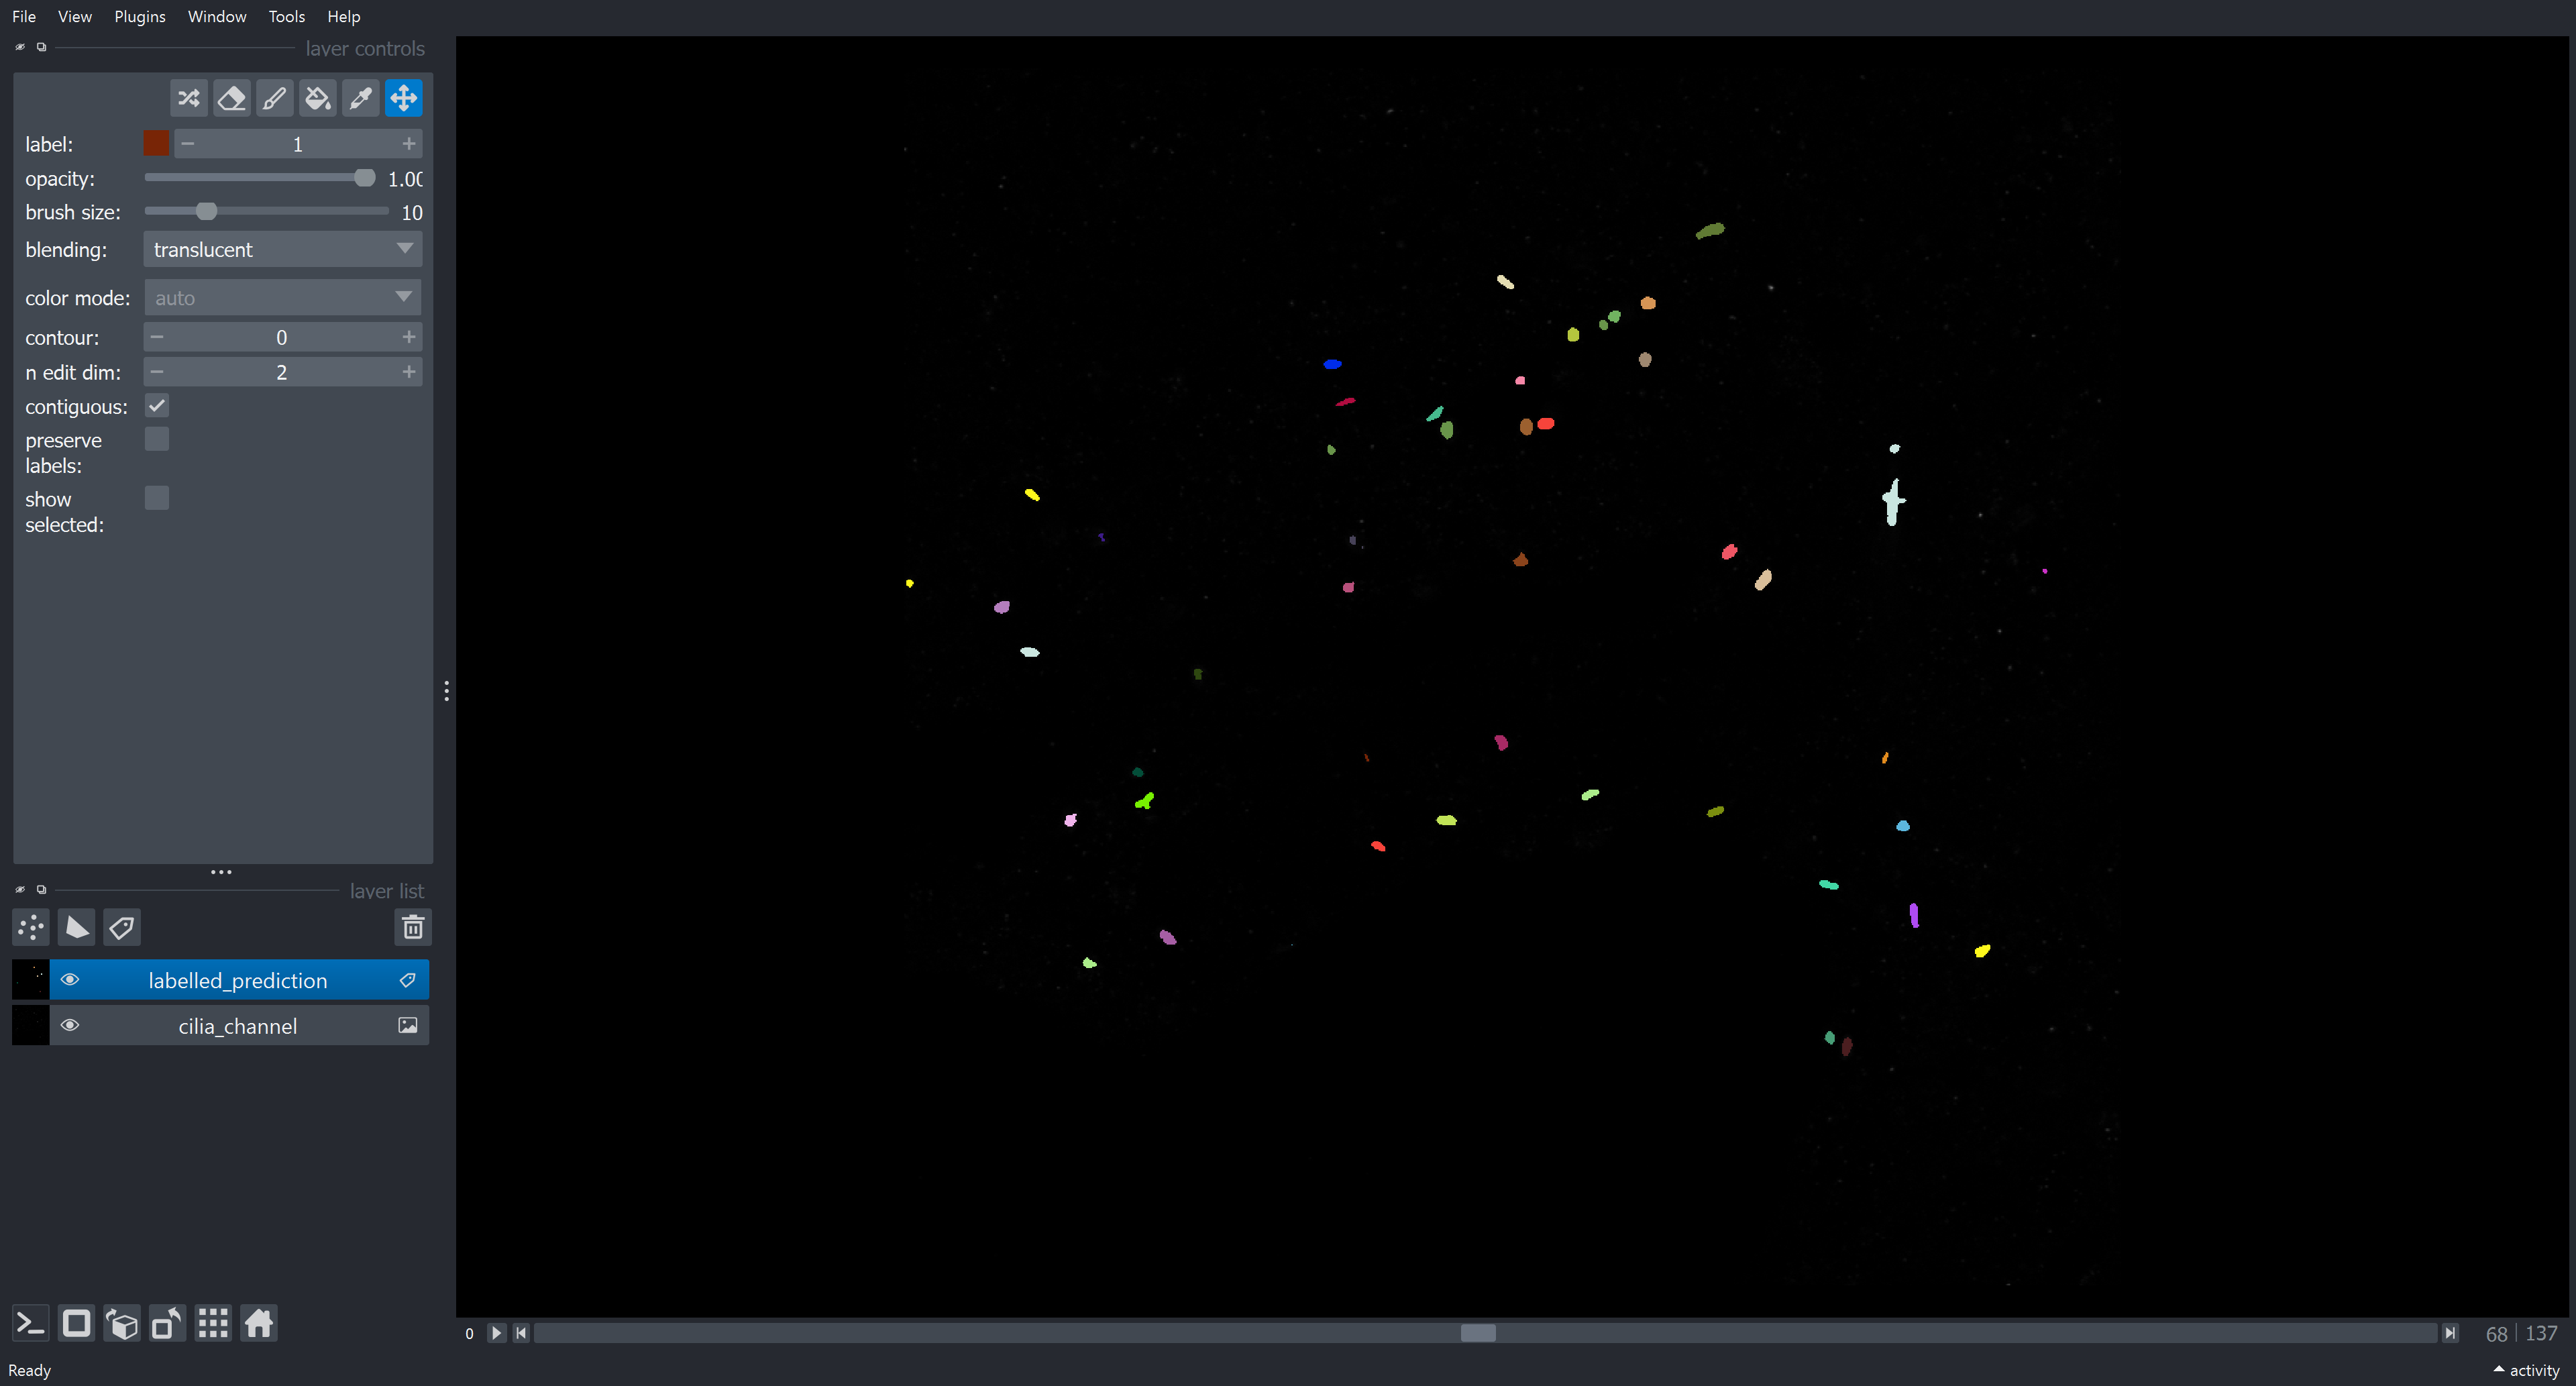

In [3]:
cilia_channel = load_rescaled_channel(filepath, 5, 1)

labelled_prediction = cilia_segmenter_cleaner(cilia_channel)

viewer = napari.Viewer()
viewer.add_image(cilia_channel)
viewer.add_labels(labelled_prediction, opacity=1)
napari.utils.nbscreenshot(viewer)

In [4]:
def intensity_median(mask, intensity_image):
    return np.median(intensity_image[mask])

In [5]:
props = regionprops_table(
    labelled_prediction,
    cilia_channel.compute(),
    properties=[
        "label",
        "area",
        "axis_major_length",
        "axis_minor_length",
        "intensity_max",
        "solidity",
    ],
    extra_properties=[intensity_median],
)
data = pd.DataFrame(props)
data

,label,area,axis_major_length,axis_minor_length,intensity_max,solidity,intensity_median
0,1,719.0,18.294934,8.525367,174.0,0.896509,12.0
1,2,837.0,21.222305,8.035641,126.0,0.873695,12.0
2,3,750.0,17.806943,8.201252,133.0,0.858124,11.0
3,4,586.0,22.383497,6.891721,125.0,0.733417,12.0
4,5,458.0,20.205238,4.148056,67.0,0.889320,11.0
...,...,...,...,...,...,...,...
416,417,940.0,21.671296,8.103212,105.0,0.887630,14.0
417,418,499.0,14.510648,7.937854,146.0,0.920664,13.0
418,419,724.0,19.850937,7.918223,190.0,0.863962,13.0
419,420,936.0,21.859566,8.815699,171.0,0.892278,16.0


c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

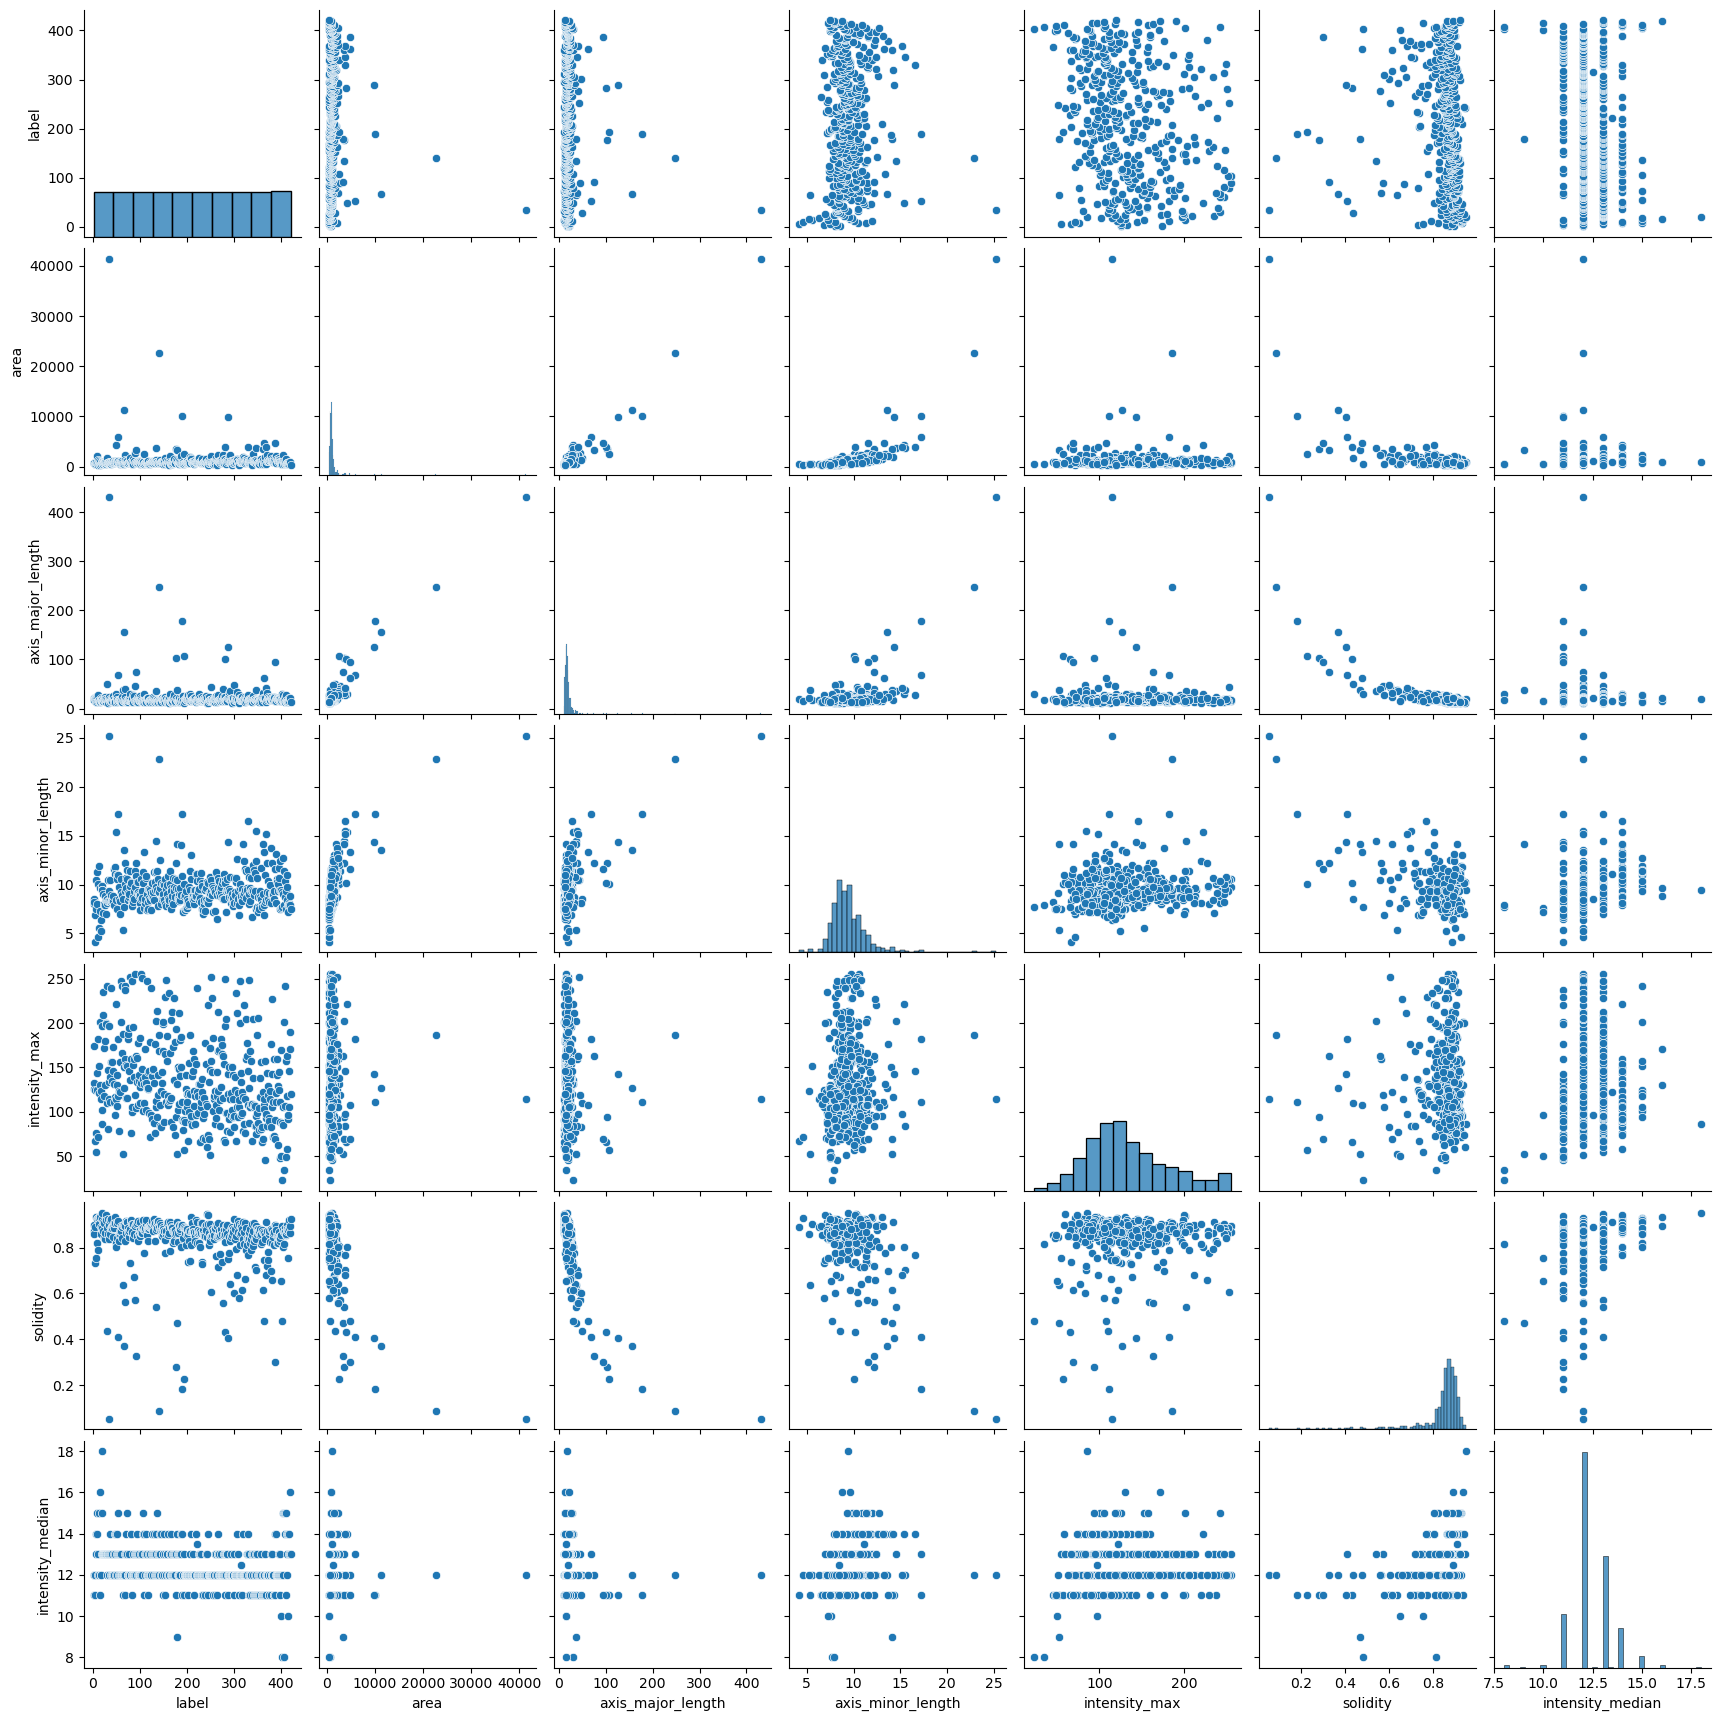

In [6]:
sns.pairplot(data)